# Using physics informed neural networks (PINNs) to solve parabolic PDEs

In this notebook, we illustrate physics informed neural networks (PINNs) to solve partial differential equations (PDEs) as proposed in

- Maziar Raissi, Paris Perdikaris, George Em Karniadakis. *Physics Informed Deep Learning (Part I): Data-driven Solutions of Nonlinear Partial Differential Equations*. [arXiv 1711.10561](https://arxiv.org/abs/1711.10561)
- Maziar Raissi, Paris Perdikaris, George Em Karniadakis. *Physics Informed Deep Learning (Part II): Data-driven Discovery of Nonlinear Partial Differential Equations*. [arXiv 1711.10566](https://arxiv.org/abs/1711.10566)
- Maziar Raissi, Paris Perdikaris, George Em Karniadakis. *Physics-informed neural networks: A deep learning framework for solving forward and inverse problems involving nonlinear partial differential equations*. J. Comp. Phys. 378 pp. 686-707 [DOI: 10.1016/j.jcp.2018.10.045](https://www.sciencedirect.com/science/article/pii/S0021999118307125)

This notebook is partially based on another implementation of the PINN approach published on [GitHub by pierremtb](https://github.com/pierremtb/PINNs-TF2.0) as well as the original code, see [Maziar Raissi on GitHub](https://github.com/maziarraissi/PINNs).

<a href="https://colab.research.google.com/github/janblechschmidt/PDEsByNNs/blob/main/PINN_Solver.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Introduction

We describe the PINN approach for approximating the solution $u:[0,T] \times \mathcal{D} \to \mathbb{R}$ of an evolution equation

$$
\begin{align}
    \partial_t u (t,x) + \mathcal{N}[u](t,x) &= 0, && (t,x) \in (0,T] \times \mathcal{D},\\
    u(0,x) &= u_0(x) \quad && x \in \mathcal{D},
\end{align}
$$

where $\mathcal{N}$ is a nonlinear differential operator acting on $u$,
$\mathcal{D} \subset \mathbb{R}^d$ a bounded domain,
$T$ denotes the final time and
$u_0: \mathcal{D} \to \mathbb{R}$ the prescribed initial data.
Although the methodology allows for different types of boundary conditions, we restrict our discussion to the inhomogeneous Dirichlet case and prescribe

$$
\begin{align}
        \hspace{7em} u(t,x) &= u_b(t,x)  && \quad (t,x) \in (0,T] \times \partial \mathcal{D},
\end{align}
$$

where $\partial \mathcal{D}$ denotes the boundary of the domain $\mathcal{D}$ and $u_b: (0,T] \times \partial \mathcal{D} \to \mathbb{R}$ the given boundary data.

## Methodology

The method constructs a neural network approximation

$$
u_\theta(t,x) \approx u(t,x)
$$

of the solution of nonlinear PDE, where $u_\theta :[0,T] \times \mathcal{D} \to \mathbb{R}$ denotes a function realized by a neural network with parameters $\theta$.

The continuous time approach for the parabolic PDE as described in ([Raissi et al., 2017 (Part I)](https://arxiv.org/abs/1711.10561)) is based on the (strong) residual of a given neural network approximation $u_\theta \colon [0,T] \times \mathcal{D} \to \mathbb{R} $ of the solution $u$, i.e.,

$$
\begin{align}
    r_\theta (t,x) := \partial_t u_\theta (t,x) + \mathcal{N}[u_\theta] (t,x).
\end{align}
$$

To incorporate this PDE residual $r_\theta$ into a loss function to be minimized, PINNs require a further differentiation to evaluate the differential operators $\partial_t u_\theta$ and $\mathcal{N}[u_\theta]$.
Thus the PINN term $r_\theta$ shares the same parameters as the original network $u_\theta(t,x)$, but respects the underlying "physics" of the nonlinear PDE.
Both types of derivatives can be easily determined through automatic differentiation with current state-of-the-art machine learning libraries, e.g., TensorFlow or PyTorch.

The PINN approach for the solution of the initial and boundary value problem now proceeds by minimization of the loss functional

$$
\begin{align}
    \phi_\theta(X) := \phi_\theta^r(X^r) + \phi_\theta^0(X^0) + \phi_\theta^b(X^b),
\end{align}
$$

where $X$ denotes the collection of training data and the loss function $\phi_\theta$ contains the following terms:

  - the mean squared residual
$$
  \begin{align*}
   \phi_\theta^r(X^r) := \frac{1}{N_r}\sum_{i=1}^{N_r} \left|r_\theta\left(t_i^r, x_i^r\right)\right|^2
\end{align*}
$$
in a number of collocation points $X^r:=\{(t_i^r, x_i^r)\}_{i=1}^{N_r} \subset (0,T] \times \mathcal{D}$, where $r_\theta$ is the physics-informed neural network,
  - the mean squared misfit with respect to the initial and boundary conditions
$$
    \begin{align*}
   \phi_\theta^0(X^0)
   :=
   \frac{1}{N_0}
   \sum_{i=1}^{N_0} \left|u_\theta\left(t_i^0, x_i^0\right) - u_0\left(x_i^0\right)\right|^2
   \quad \text{ and } \quad
   \phi_\theta^b(X^b)
   :=
   \frac{1}{N_b}
   \sum_{i=1}^{N_b} \left|u_\theta\left(t_i^b, x_i^b\right) - u_b\left(t_i^b, x_i^b\right)\right|^2
    \end{align*}
$$
in a number of points $X^0:=\{(t^0_i,x^0_i)\}_{i=1}^{N_0} \subset \{0\} \times \mathcal{D}$ and $X^b:=\{(t^b_i,x^b_i)\}_{i=1}^{N_b} \subset (0,T] \times \partial \mathcal{D}$, where $u_\theta$ is the neural network approximation of the solution $u\colon[0,T] \times \mathcal{D} \to \mathbb{R}$.

Note that the training data $X$ consists entirely of time-space coordinates.


## Example: Burgers equation

To illustrate the PINN approach we consider the one-dimensional Burgers equation on the spatial domain $\mathcal{D} = [-1,1]$

$$
\begin{aligned}
    \partial_t u + u \, \partial_x u - (0.01/\pi) \, \partial_{xx} u &= 0, \quad &&\quad (t,x) \in (0,1] \times (-1,1),\\
   u(0,x) &= - \sin(\pi \, x),                 \quad &&\quad x \in [-1,1],\\
   u(t,-1) = u(t,1) &= 0,                      \quad &&\quad t \in (0,1].
\end{aligned}
$$

This PDE arises in various disciplines such as traffic flow, fluid mechanics and gas dynamics, and can be derived from the Navier-Stokes equations, see
([Basdevant et al., 1986](https://www.researchgate.net/publication/222935980_Spectral_and_finite_difference_solutions_of_Burgers_equation)).

### 1. Import necessary packages and set problem specific data
This code runs with TensorFlow version `2.3.0`.
The implementation relies mainly on the scientific computing library [NumPy](https://numpy.org/doc/stable/user/whatisnumpy.html) and the machine learning library [TensorFlow](https://www.tensorflow.org/).

All computations were performed on an Intel i7 CPU (8th Gen) with 16 GByte DDR3 RAM (2133 MHz) within a couple of minutes.

In [16]:
# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Set data type
DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE)

# Set constants
epsilon = 0.005

# Define functions for the PDE
def a1(x, y):
    return 0

def a2(x, y):
    return 0

def f(x, y, u):
    return u

# Define boundary conditions
def g1(y):
    return tf.ones_like(y, dtype=DTYPE)

def g2(y):
    return tf.ones_like(y, dtype=DTYPE)

def g3(x):
    return tf.ones_like(x, dtype=DTYPE)

def g4(x):
    return tf.ones_like(x, dtype=DTYPE)

# Define residual of the PDE
def fun_r(x, y, u, u_x, u_y, u_xx, u_yy):
    return epsilon * (u_xx + u_yy) - a1(x, y) * u_x - a2(x, y) * u_y - f(x, y, u)

### 2. Generate a set of collocation points

We assume that the collocation points $X_r$ as well as the points for the initial time and boundary data $X_0$ and $X_b$ are generated by random sampling from a uniform distribution.
Although uniformly distributed data are sufficient in our experiments, the authors of
([Raissi et al., 2017 (Part I)](https://arxiv.org/abs/1711.10561))
employed a space-filling Latin hypercube sampling strategy ([Stein, 1987](https://www.tandfonline.com/doi/abs/10.1080/00401706.1987.10488205)).
Our numerical experiments indicate that this strategy slightly improves the observed convergence rate, but for simplicity the code examples accompanying this paper employ uniform sampling throughout.
We choose training data of size $N_0 = N_b =50$ and $N_f=10000$.

In [17]:
# Set number of data points
N_b = 50   # Количество точек для граничных условий
N_r = 10000  # Количество точек для коллокации (для внутренней области)

# Set boundary
xmin, xmax = 0.0, 2.0
ymin, ymax = 0.0, 1.0

# Lower bounds
lb = tf.constant([xmin, ymin], dtype=DTYPE)
# Upper bounds
ub = tf.constant([xmax, ymax], dtype=DTYPE)

# Set random seed for reproducible results
tf.random.set_seed(0)

# Boundary data

# Левая граница от (0, 1) до (0, 0.2)
x_b1 = tf.ones((N_b, 1), dtype=DTYPE) * lb[0]
y_b1 = tf.random.uniform((N_b, 1), 0.2, 1.0, dtype=DTYPE)
X_b1 = tf.concat([x_b1, y_b1], axis=1)

# Левая граница от (0.50, 0.2) до (0.50, 0)
x_b2 = tf.ones((N_b, 1), dtype=DTYPE) * 0.5
y_b2 = tf.random.uniform((N_b, 1), 0.0, 0.2, dtype=DTYPE)
X_b2 = tf.concat([x_b2, y_b2], axis=1)

# Левая граница от (1.25, 0) до (1.75, 0.2)
x_b3 = tf.random.uniform((N_b, 1), 1.25, 1.75, dtype=DTYPE)
a = (0.2 - 0) / (1.75 - 1.25)  # Наклон линии
b = 0  # y = 0 в точке x = 1.25
y_b3 = a * (x_b3 - 1.25)  # Сдвиг линии
X_b3 = tf.concat([x_b3, y_b3], axis=1)

# Нижняя граница от (0, 0.2) до (0.5, 0.2)
x_b4 = tf.random.uniform((N_b, 1), 0.0, 0.5, dtype=DTYPE)
y_b4 = tf.ones((N_b, 1), dtype=DTYPE) * 0.2
X_b4 = tf.concat([x_b4, y_b4], axis=1)

# Нижняя граница от (0.5, 0) до (1.25, 0)
x_b5 = tf.random.uniform((N_b, 1), 0.5, 1.25, dtype=DTYPE)
y_b5 = tf.ones((N_b, 1), dtype=DTYPE) * lb[1]
X_b5 = tf.concat([x_b5, y_b5], axis=1)

# Нижняя граница от (1.75, 0.2) до (2, 0.2)
x_b6 = tf.random.uniform((N_b, 1), 1.75, 2.0, dtype=DTYPE)
y_b6 = tf.ones((N_b, 1), dtype=DTYPE) * 0.2
X_b6 = tf.concat([x_b6, y_b6], axis=1)

# Правая граница от (2, 0.2) до (2, 1)
x_b7 = tf.ones((N_b, 1), dtype=DTYPE) * ub[0]
y_b7 = tf.random.uniform((N_b, 1), 0.2, 1.0, dtype=DTYPE)
X_b7 = tf.concat([x_b7, y_b7], axis=1)

# Верхняя граница от (0, 1) до (2, 1)
x_b8 = tf.random.uniform((N_b, 1), lb[0], ub[0], dtype=DTYPE)
y_b8 = tf.ones((N_b, 1), dtype=DTYPE) * ub[1]
X_b8 = tf.concat([x_b8, y_b8], axis=1)

# Объединяем все граничные точки
X_b = tf.concat([X_b1, X_b2, X_b3, X_b4, X_b5, X_b6, X_b7, X_b8], axis=0)

# Evaluate boundary conditions at the boundary points
u_b1 = g1(X_b1[:, 1:2])
u_b2 = g2(X_b2[:, 1:2])
u_b3 = g3(X_b3[:, 0:1])
u_b4 = g4(X_b4[:, 0:1])
u_b5 = g1(X_b5[:, 1:2])
u_b6 = g2(X_b6[:, 1:2])
u_b7 = g1(X_b7[:, 1:2])
u_b8 = g2(X_b8[:, 1:2])

u_b = tf.concat([u_b1, u_b2, u_b3, u_b4, u_b5, u_b6, u_b7, u_b8], axis=0)

# Draw uniformly sampled collocation points
x_r = tf.random.uniform((N_r, 1), lb[0], ub[0], dtype=DTYPE)
y_r = tf.random.uniform((N_r, 1), lb[1], ub[1], dtype=DTYPE)

# Убираем точки, которые попадают в вырезанную область
mask = ~(((x_r > 1.75) & (x_r < 2) & (y_r < 0.2)) | ((x_r > 0) & (x_r < 0.5) & (y_r < 0.2)) | ((x_r > 1.25) & (x_r < 1.75) & (y_r < a * (x_r - 1.25))))

x_r_filtered = tf.boolean_mask(x_r, mask)
y_r_filtered = tf.boolean_mask(y_r, mask)

# Преобразование одномерных массивов обратно в двумерные
x_r_filtered = tf.expand_dims(x_r_filtered, axis=1)
y_r_filtered = tf.expand_dims(y_r_filtered, axis=1)

X_r_filtered = tf.concat([x_r_filtered, y_r_filtered], axis=1)

# Collect boundary data in lists
X_data = [X_b]
u_data = [u_b]

# Save collocation points to files
np.savetxt("initial_collocation_points_x.csv", x_r_filtered.numpy(), delimiter=",")
np.savetxt("initial_collocation_points_y.csv", y_r_filtered.numpy(), delimiter=",")

Next, we illustrate the collocation points (red circles) and the positions where the boundary and initial conditions will be enforced (cross marks, color indicates value).

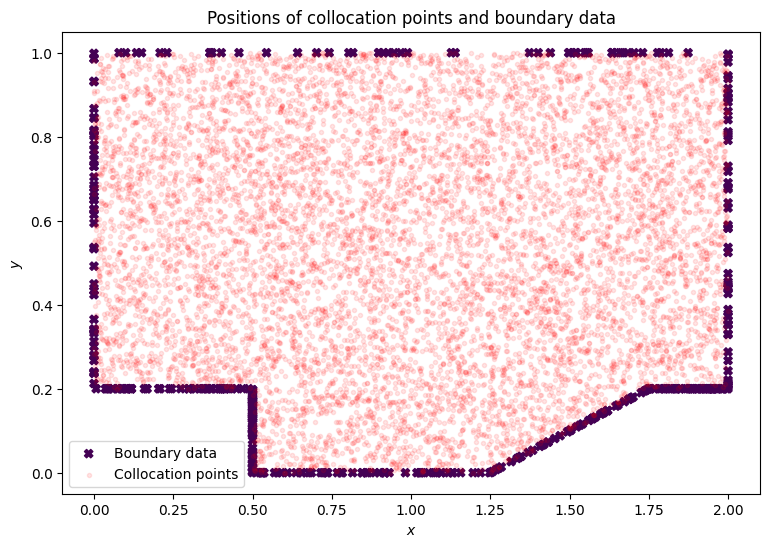

In [18]:
import matplotlib.pyplot as plt

# Set up meshgrid
N = 600
xspace = np.linspace(lb[0].numpy(), ub[0].numpy(), N + 1)
yspace = np.linspace(lb[1].numpy(), ub[1].numpy(), N + 1)
X, Y = np.meshgrid(xspace, yspace)
Xgrid = np.vstack([X.flatten(), Y.flatten()]).T

# Определяем min и max значения для u_b
vmin, vmax = u_b.numpy().min(), u_b.numpy().max()

# Plot collocation points and boundary data
fig = plt.figure(figsize=(9,6))
plt.scatter(X_b[:, 0], X_b[:, 1], c=u_b, marker='X', vmin=vmin, vmax=vmax, label='Boundary data')
plt.scatter(X_r_filtered[:, 0], X_r_filtered[:, 1], c='r', marker='.', alpha=0.1, label='Collocation points')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Positions of collocation points and boundary data')
plt.legend()

# Save the figure if needed
#plt.savefig('Xdata_Diffusion_Convection.pdf', bbox_inches='tight', dpi=300)

plt.show()

### 3. Set up network architecture

In this example, adopted from
([Raissi et al., 2017 (Part I)](https://arxiv.org/abs/1711.10561)), we assume a feedforward neural network of the following structure:
- the input is scaled elementwise to lie in the interval $[-1,1]$,
- followed by 8 fully connected layers each containing 20 neurons and each followed by a hyperbolic tangent activation function,
- one fully connected output layer.

This setting results in a network with $3021$ trainable parameters (first hidden layer: $2 \cdot 20 + 20 = 60$; seven intermediate layers: each $20 \cdot 20 + 20 = 420$; output layer: $20 \cdot 1 + 1 = 21$).

In [19]:
def init_model(num_hidden_layers=8, num_neurons_per_layer=20):
    # Initialize a feedforward neural network
    model = tf.keras.Sequential()

    # Input is two-dimensional (two spatial dimensions)
    model.add(tf.keras.Input(shape=(2,)))

    # Introduce a scaling layer to map input to [lb, ub]
    scaling_layer = tf.keras.layers.Lambda(
        lambda x: 2.0 * (x - lb) / (ub - lb) - 1.0)
    model.add(scaling_layer)

    # Append hidden layers
    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,
                                        activation=tf.keras.activations.get('tanh'),
                                        kernel_initializer='glorot_normal'))

    # Output is one-dimensional
    model.add(tf.keras.layers.Dense(1))

    return model

### 4. Define routines to determine loss and gradient

In the following code cell, we define a function which evaluates the residual

$$
\begin{align}
    r_\theta (t,x) := \partial_t u_\theta (t,x) + \mathcal{N}[u_\theta] (t,x).
\end{align}
$$

of the nonlinear PDE in the points $X_r = \{(t^r_i,x^r_i)\}_{i=1}^{N_r}$.
To compute the necessary partial derivatives we use the automatic differentiation capabilities of TensorFlow.

For the Burgers equation, this entails computing $\partial_t u_\theta$, $\partial_x u_\theta$ and $\partial_{xx} u_\theta$.
In TensorFlow, this is done via a `GradientTape`, see also the [documentation](https://www.tensorflow.org/api_docs/python/tf/GradientTape), which keeps track of the `watched` variables, in our case `t` and `x`, in order to compute the derivatives.

In [20]:
def get_r(model, X_r):

    # A tf.GradientTape is used to compute derivatives in TensorFlow
    with tf.GradientTape(persistent=True) as tape:
        # Split x and y to compute partial derivatives
        x, y = X_r[:, 0:1], X_r[:, 1:2]

        # Variables x and y are watched during tape
        # to compute derivatives u_x and u_y
        tape.watch(x)
        tape.watch(y)

        # Determine residual
        u = model(tf.concat([x, y], axis=1))

        # Compute gradient u_x and u_y within the GradientTape
        # since we need second derivatives
        u_x = tape.gradient(u, x)
        u_y = tape.gradient(u, y)

    u_xx = tape.gradient(u_x, x)
    u_yy = tape.gradient(u_y, y)

    del tape

    return fun_r(x, y, u, u_x, u_y, u_xx, u_yy)

The next function computes the loss for our model

$$
\begin{align}
    \phi_\theta(X) := \phi_\theta^r(X^r) + \phi_\theta^0(X^0) + \phi_\theta^b(X^b),
\end{align}
$$

as a function of our the training data.
The collocation points are given by `X_r`, the initial and boundary data is contained in `X_data = [X_0, X_b]` and `u_data = [u_0, u_b]`.

In [21]:
def compute_loss(model, X_r, X_data, u_data, W=100):
    # Compute phi^r
    r = get_r(model, X_r)
    phi_r = tf.reduce_mean(tf.square(r))

    # Initialize loss
    loss = phi_r

    # Add boundary loss to the total loss with weight coefficient W
    for i in range(len(X_data)):
        u_pred = model(X_data[i])
        loss += W * tf.reduce_mean(tf.square(u_data[i] - u_pred))

    return loss

The next function computes the gradient of the loss function $\phi_\theta$ with respect to the unknown variables in the model, also called `trainable_variables` in TensorFlow, i.e. $\nabla_\theta \phi_\theta$.
This is also done via a `GradientTape`, but now it keeps track of the parameters $\theta$ in our model, which can be accessed by `model.trainable_variables`.

In [22]:
def get_grad(model, X_r, X_data, u_data, W=100):
    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with
        # respect to trainable variables
        tape.watch(model.trainable_variables)
        loss = compute_loss(model, X_r, X_data, u_data, W)

    g = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, g

### 5. Set up optimizer and train model

Next we initialize the model, set the learning rate to the step function

$$
\delta(n) = 0.01 \, \textbf{1}_{\{n < 1000\}} + 0.001 \, \textbf{1}_{\{1000 \le n < 3000\}} + 0.0005 \, \textbf{1}_{\{3000 \le n\}}
$$

which decays in a piecewise constant fashion, and set up a `tf.keras.optimizer` to train the model.

In [23]:
# Initialize model aka u_\theta
model = init_model()

# We choose a piecewise decay of the learning rate, i.e., the
# step size in the gradient descent type algorithm
# the first 1000 steps use a learning rate of 0.01
# from 1000 - 3000: learning rate = 0.001
# from 3000 onwards: learning rate = 0.0005
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000, 3000], [1e-2, 1e-3, 5e-4])

# Choose the optimizer
optim = tf.keras.optimizers.Adam(learning_rate=lr)

Train the model for $N=5000$ epochs (takes approximately 3 minutes).
Here, we set up a function `train_step()` which performs one training step.

*Note*: The `@tf.function` is a so-called `Decorator` within Python. This particular decorator redefines the function that follows, in our case `train_step`, as a TensorFlow graph which may speed up the training significantly.

In [24]:
from time import time

# Define one training step as a TensorFlow function to increase speed of training
@tf.function
def train_step(W=100):
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = get_grad(model, X_r_filtered, X_data, u_data, W)

    # Perform gradient descent step
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))

    return loss

# Number of training epochs
N = 5000
hist = []

# Start timer
t0 = time()

for i in range(N+1):

    loss = train_step()

    # Append current loss to hist
    hist.append(loss.numpy())

    # Output current loss after 50 iterates
    if i % 50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i, loss))

# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

It 00000: loss = 1.00648117e+02
It 00050: loss = 1.00639296e+00
It 00100: loss = 9.76568043e-01
It 00150: loss = 9.65360045e-01
It 00200: loss = 9.30778086e-01
It 00250: loss = 8.31097305e-01
It 00300: loss = 1.05984783e+00
It 00350: loss = 8.30711603e-01
It 00400: loss = 6.38227224e-01
It 00450: loss = 8.09962630e-01
It 00500: loss = 5.86667657e-01
It 00550: loss = 5.14805555e-01
It 00600: loss = 6.10922039e-01
It 00650: loss = 4.72430199e-01
It 00700: loss = 4.50917125e-01
It 00750: loss = 5.44853508e-01
It 00800: loss = 4.13121641e-01
It 00850: loss = 3.62839043e-01
It 00900: loss = 4.11647081e-01
It 00950: loss = 3.46168935e-01
It 01000: loss = 3.59463513e-01
It 01050: loss = 3.36685926e-01
It 01100: loss = 3.32021236e-01
It 01150: loss = 3.27735901e-01
It 01200: loss = 3.23653609e-01
It 01250: loss = 3.19697976e-01
It 01300: loss = 3.15830916e-01
It 01350: loss = 3.12032312e-01
It 01400: loss = 3.08292329e-01
It 01450: loss = 3.04606527e-01
It 01500: loss = 3.00973415e-01
It 01550

### Plot solution

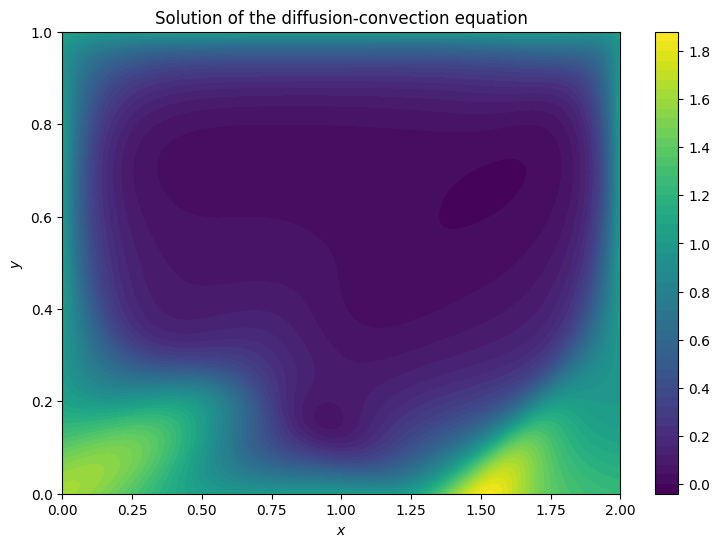

In [25]:
import matplotlib.pyplot as plt

# Set up meshgrid
N = 600
xspace = np.linspace(lb[0].numpy(), ub[0].numpy(), N + 1)
yspace = np.linspace(lb[1].numpy(), ub[1].numpy(), N + 1)
X, Y = np.meshgrid(xspace, yspace)
Xgrid = np.vstack([X.flatten(), Y.flatten()]).T

# Determine predictions of u(x, y)
upred = model(tf.cast(Xgrid, DTYPE))

# Reshape upred
U = upred.numpy().reshape(N + 1, N + 1)

# Contour plot of solution u(x, y)
fig, ax = plt.subplots(figsize=(9, 6))
contour = ax.contourf(X, Y, U, levels=50, cmap='viridis')
fig.colorbar(contour)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title('Solution of the diffusion-convection equation')
plt.show()

### Plot the evolution of loss

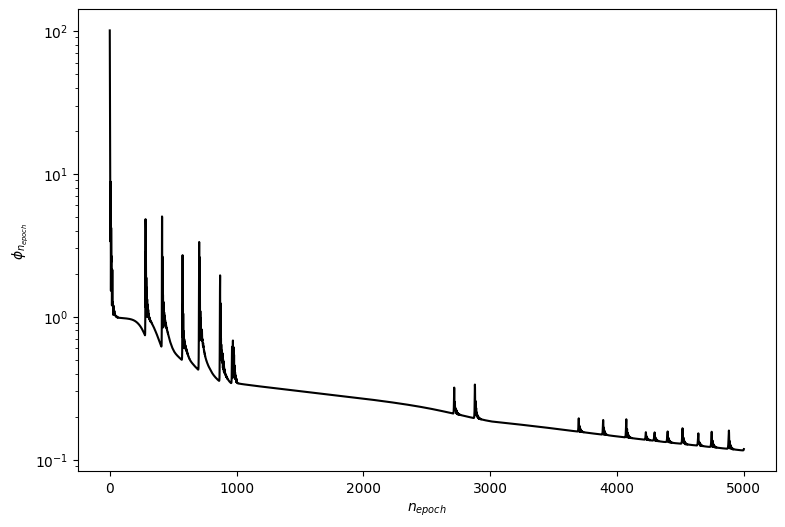

In [26]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(hist)), hist,'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('$\\phi_{n_{epoch}}$');

## Class implementation of PINNs

In this section, we implement PINNs as a class which can be used for further testing. Here, we derive the class `PINN_NeuralNet` from `tf.keras.Model`.

Required arguments are the lower bound `lb` and upper bound `ub`.

In [27]:
# Define model architecture
class PINN_NeuralNet(tf.keras.Model):
    """ Set basic architecture of the PINN model."""

    def __init__(self, lb, ub,
            output_dim=1,
            num_hidden_layers=8,
            num_neurons_per_layer=20,
            activation='tanh',
            kernel_initializer='glorot_normal',
            **kwargs):
        super().__init__(**kwargs)

        self.num_hidden_layers = num_hidden_layers
        self.output_dim = output_dim
        self.lb = lb
        self.ub = ub

        # Define NN architecture
        self.scale = tf.keras.layers.Lambda(
            lambda x: 2.0*(x - lb)/(ub - lb) - 1.0)
        self.hidden = [tf.keras.layers.Dense(num_neurons_per_layer,
                             activation=tf.keras.activations.get(activation),
                             kernel_initializer=kernel_initializer)
                           for _ in range(self.num_hidden_layers)]
        self.out = tf.keras.layers.Dense(output_dim)

    def call(self, X):
        """Forward-pass through neural network."""
        Z = self.scale(X)
        for i in range(self.num_hidden_layers):
            Z = self.hidden[i](Z)
        return self.out(Z)

Next, we derive a class `PINNSolver` which can be used as a base class.
It possesses two methods to solve the PDE:
  1. the method `solve_with_TFoptimizer` uses a `TensorFlow` optimizer object as input, e.g., the `AdamOptimizer` above;
  2. the method `solve_with_LBFGS` resembles the LBFGS method proposed in the original paper using an LBFGS method provided by [`SciPy`](https://www.scipy.org/).

In [28]:
import scipy.optimize
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

class PINNSolver():
    def __init__(self, model, X_r, W=100):
        self.model = model
        self.W = W  # Весовой коэффициент

        # Store collocation points
        self.x = X_r[:, 0:1]
        self.y = X_r[:, 1:2]

        # Initialize history of losses and global iteration counter
        self.hist = []
        self.iter = 0

    def get_r(self):
        with tf.GradientTape(persistent=True) as tape:
            # Watch variables representing x and y during this GradientTape
            tape.watch(self.x)
            tape.watch(self.y)

            # Compute current values u(x, y)
            u = self.model(tf.concat([self.x, self.y], axis=1))

            # Compute gradients u_x и u_y
            u_x = tape.gradient(u, self.x)
            u_y = tape.gradient(u, self.y)

        u_xx = tape.gradient(u_x, self.x)
        u_yy = tape.gradient(u_y, self.y)

        del tape

        return self.fun_r(self.x, self.y, u, u_x, u_y, u_xx, u_yy)

    def loss_fn(self, X, u):
        # Compute phi_r
        r = self.get_r()
        phi_r = tf.reduce_mean(tf.square(r))

        # Initialize loss
        loss = phi_r

        # Add boundary loss to the total loss
        for i in range(len(X)):
            u_pred = self.model(X[i])
            loss += self.W * tf.reduce_mean(tf.square(u[i] - u_pred))

        return loss

    def get_grad(self, X, u):
        with tf.GradientTape(persistent=True) as tape:
            # This tape is for derivatives with
            # respect to trainable variables
            tape.watch(self.model.trainable_variables)
            loss = self.loss_fn(X, u)

        g = tape.gradient(loss, self.model.trainable_variables)
        del tape

        return loss, g

    def fun_r(self, x, y, u, u_x, u_y, u_xx, u_yy):
        """Residual of the PDE"""
        return epsilon * (u_xx + u_yy) - a1(x, y) * u_x - a2(x, y) * u_y - f(x, y, u)

    def solve_with_TFoptimizer(self, optimizer, X, u, N=1001):
        """This method performs a gradient descent type optimization."""

        @tf.function
        def train_step():
            loss, grad_theta = self.get_grad(X, u)

            # Perform gradient descent step
            optimizer.apply_gradients(zip(grad_theta, self.model.trainable_variables))
            return loss

        for i in range(N):
            loss = train_step()
            self.current_loss = loss.numpy()
            self.callback()

    def solve_with_ScipyOptimizer(self, X, u, method='L-BFGS-B', **kwargs):
        """This method provides an interface to solve the learning problem
        using a routine from scipy.optimize.minimize.
        (Tensorflow 1.xx had an interface implemented, which is not longer
        supported in Tensorflow 2.xx.)
        Type conversion is necessary since scipy-routines are written in Fortran
        which requires 64-bit floats instead of 32-bit floats."""

        def get_weight_tensor():
            """Function to return current variables of the model
            as 1d tensor as well as corresponding shapes as lists."""

            weight_list = []
            shape_list = []

            # Loop over all variables, i.e. weight matrices, bias vectors и unknown parameters
            for v in self.model.variables:
                shape_list.append(v.shape)
                weight_list.extend(v.numpy().flatten())

            weight_list = tf.convert_to_tensor(weight_list)
            return weight_list, shape_list

        x0, shape_list = get_weight_tensor()

        def set_weight_tensor(weight_list):
            """Function which sets list of weights
            to variables in the model."""
            idx = 0
            for v in self.model.variables:
                vs = v.shape

                # Weight matrices
                if len(vs) == 2:
                    sw = vs[0] * vs[1]
                    new_val = tf.reshape(weight_list[idx:idx + sw], (vs[0], vs[1]))
                    idx += sw

                # Bias vectors
                elif len(vs) == 1:
                    new_val = weight_list[idx:idx + vs[0]]
                    idx += vs[0]

                # Variables (in case of parameter identification setting)
                elif len(vs) == 0:
                    new_val = weight_list[idx]
                    idx += 1

                # Assign variables (Casting necessary since scipy requires float64 type)
                v.assign(tf.cast(new_val, DTYPE))

        def get_loss_and_grad(w):
            """Function that provides current loss and gradient
            w.r.t the trainable variables as vector. This is mandatory
            for the LBFGS minimizer from scipy."""

            # Update weights in model
            set_weight_tensor(w)
            # Determine value of \phi и gradient w.r.t. \theta at w
            loss, grad = self.get_grad(X, u)

            # Store current loss for callback function
            loss = loss.numpy().astype(np.float64)
            self.current_loss = loss

            # Flatten gradient
            grad_flat = []
            for g in grad:
                grad_flat.extend(g.numpy().flatten())

            # Gradient list to array
            grad_flat = np.array(grad_flat, dtype=np.float64)

            # Return value and gradient of \phi as tuple
            return loss, grad_flat

        return scipy.optimize.minimize(fun=get_loss_and_grad,
                                       x0=x0,
                                       jac=True,
                                       method=method,
                                       callback=self.callback,
                                       **kwargs)

    def callback(self, xr=None):
        if self.iter % 50 == 0:
            print('It {:05d}: loss = {:10.8e}'.format(self.iter, self.current_loss))
        self.hist.append(self.current_loss)
        self.iter += 1

    def plot_solution(self, u_max=2, **kwargs):
        N = 600
        xspace = np.linspace(self.model.lb.numpy()[0], self.model.ub.numpy()[0], N + 1)
        yspace = np.linspace(self.model.lb.numpy()[1], self.model.ub.numpy()[1], N + 1)
        X, Y = np.meshgrid(xspace, yspace)
        Xgrid = np.vstack([X.flatten(), Y.flatten()]).T
        upred = self.model(tf.cast(Xgrid, DTYPE))

        # Define the mask
        f = np.ones((N + 1, N + 1))
        mask = np.ones_like(f, dtype=bool)

        # Define mask conditions based on the boundaries
        mask &= ~((X >= 0) & (X <= 0.5) & (Y <= 0.2))
        mask &= ~((X >= 1.75) & (X <= 2) & (Y <= 0.2))

        # Define the line equation y = ax + b for (1.25, 0) to (1.75, 0.2)
        a = 0.2 / (1.75 - 1.25)
        b = 0  # y = 0 в точке x = 1.25
        mask &= ~((X >= 1.25) & (X <= 1.75) & (Y <= a * (X - 1.25) + b))

        # Apply mask
        masked_f = np.ma.masked_array(f, mask=mask)

        # Reshape upred
        U = upred.numpy().reshape(N + 1, N + 1)

        # Contour plot of solution u(x, y)
        fig, ax = plt.subplots(figsize=(9, 6))
        plt.pcolormesh(X, Y, masked_f, zorder=2, cmap="gray", vmin=-1)
        contour = ax.contourf(X, Y, U, levels=50, cmap='viridis', vmin=0, vmax=u_max)
        fig.colorbar(contour)
        ax.set_xlabel('$x$')
        ax.set_ylabel('$y$')
        ax.set_title('Solution of the diffusion-convection equation')
        return ax

    def plot_loss_history(self, ax=None):
        if not ax:
            fig = plt.figure(figsize=(7, 5))
            ax = fig.add_subplot(111)
        ax.semilogy(range(len(self.hist)), self.hist, 'k-')
        ax.set_xlabel('$n_{epoch}$')
        ax.set_ylabel('$\\phi^{n_{epoch}}$')
        return ax

### Burgers equation with L-BFGS

The following code cell shows how the new classes `PINN_NeuralNet` and `PINNSolver` can be used to solve the Burgers equation, this time using the `SciPy` implementation of L-BFGS (takes around 3 minutes).

In [29]:
# Initialize model
model = PINN_NeuralNet(lb, ub)
model.build(input_shape=(None, 2))

# Initialize PINN solver
W = 100  # Весовой коэффициент
solver = PINNSolver(model, X_r_filtered, W=W)

# Decide which optimizer should be used
mode = 'ScipyOptimizer'

# Start timer
t0 = time()

if mode == 'TFoptimizer':
    # Choose optimizer
    lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000, 3000], [1e-2, 1e-3, 5e-4])
    optim = tf.keras.optimizers.Adam(learning_rate=lr)
    solver.solve_with_TFoptimizer(optim, X_data, u_data, N=4001)
elif mode == 'ScipyOptimizer':
    solver.solve_with_ScipyOptimizer(X_data, u_data,
                                     method='L-BFGS-B',
                                     options={'maxiter': 50000,
                                              'maxfun': 50000,
                                              'maxcor': 50,
                                              'maxls': 50,
                                              'ftol': 1.0*np.finfo(float).eps})

# Print computation time
print('\nComputation time: {} seconds'.format(time() - t0))

# Save collocation points to files
np.savetxt("trained_collocation_points_x.csv", X_r_filtered[:, 0].numpy(), delimiter=",")
np.savetxt("trained_collocation_points_y.csv", X_r_filtered[:, 1].numpy(), delimiter=",")

It 00000: loss = 4.03814793e+00
It 00050: loss = 8.19706678e-01
It 00100: loss = 5.67027628e-01
It 00150: loss = 4.97924626e-01
It 00200: loss = 4.27190185e-01
It 00250: loss = 3.58123720e-01
It 00300: loss = 2.93536663e-01
It 00350: loss = 2.48764381e-01
It 00400: loss = 2.24280775e-01
It 00450: loss = 2.13865429e-01
It 00500: loss = 2.04520017e-01
It 00550: loss = 1.93127573e-01
It 00600: loss = 1.83510929e-01
It 00650: loss = 1.72339588e-01
It 00700: loss = 1.62289783e-01
It 00750: loss = 1.48145199e-01
It 00800: loss = 1.28914610e-01
It 00850: loss = 1.16433576e-01
It 00900: loss = 1.07743546e-01
It 00950: loss = 9.77399573e-02
It 01000: loss = 9.32121277e-02
It 01050: loss = 8.94355476e-02
It 01100: loss = 8.57704803e-02
It 01150: loss = 8.30562413e-02
It 01200: loss = 7.97149539e-02
It 01250: loss = 7.70782009e-02
It 01300: loss = 7.34436586e-02
It 01350: loss = 7.07214177e-02
It 01400: loss = 6.87830150e-02
It 01450: loss = 6.58290163e-02
It 01500: loss = 6.35132268e-02
It 01550

Plot solution and loss history.

<Axes: xlabel='$n_{epoch}$', ylabel='$\\phi^{n_{epoch}}$'>

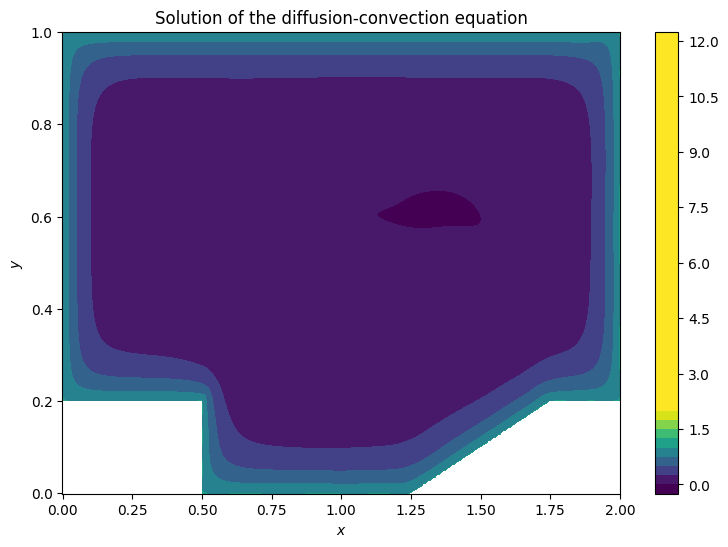

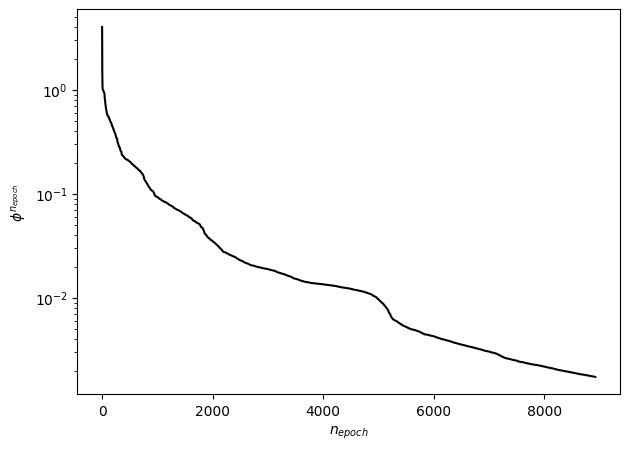

In [31]:
solver.plot_solution(u_max=2)
solver.plot_loss_history()